In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 361 (delta 108), reused 92 (delta 67), pack-reused 171
Receiving objects: 100% (361/361), 55.83 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=d4793c0dcc0c41237bb9f87c4cfda600ae9297ef542e80e27890b4e50c42eadb
  Stored in directory: /tmp/pip-ephem-wheel-cache-behdqf8r/wheels/55/59/29/0fb1c6356521

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import tqdm, trange
import numpy as np
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [4]:
class Encoder(nn.Module): 
    def __init__(self, ld): 
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU()
                                  )
        
        self.lin = nn.Linear(4 * 4 * 128, ld)

    def forward(self, x):
        return self.lin(self.conv(x).flatten(1))

In [5]:
class Decoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self.lin = nn.Sequential(nn.Linear(ld, 4 * 4 * 128), nn.ReLU())

        self.conv = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 2, 1), nn.ReLU(), 
                                  nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(), 
                                  nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(32, 1, 3, 1, 1), nn.Tanh()
                                 )

    def forward(self, x):
        return self.conv(self.lin(x).view(-1, 128, 4, 4))

In [6]:
class Discriminator(nn.Module): 
    def __init__(self, hd): 
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU()
                                 )
        
        self.lin = nn.Sequential(nn.Linear(4 * 4 * 128, hd), nn.ReLU(),
                                 nn.Linear(hd, hd), nn.ReLU(),
                                 nn.Linear(hd, 1), nn.Sigmoid()
                                )

    def forward(self, x): 
        return self.lin(self.conv(x).flatten(1))

In [7]:
class ContextEncoderModel(nn.Module):
    def __init__(self, ld, hd):
        super().__init__()
        self.encoder = Encoder(ld=ld)
        self.decoder = Decoder(ld=ld)
        self.discriminator = Discriminator(hd=hd)
    
    def masking(self, image, sq_size=14):
        bs, ch, height, width = image.shape
        w = np.random.randint(0, width - sq_size, size=bs)
        h = np.random.randint(0, height - sq_size, size=bs)
        maska = torch.zeros_like(image)
        for m, i, j in zip(maska, h, w):
            m[:, i: sq_size + i, j: sq_size + j] = 1.0
        return maska

    def calc_loss(self, b):
      m = self.masking(b)   
      b_rec = self.decoder(self.encoder((1 - m) * b))
      loss_rec = m * F.mse_loss(b_rec, b, reduction='none')
      loss_rec = loss_rec.reshape(b.shape[0], -1).mean(dim=1) 
      fakeD, realD = self.discriminator(b_rec), self.discriminator(b)
      loss_fake = F.binary_cross_entropy(fakeD, torch.ones_like(fakeD))
      loss_tot = loss_fake + loss_rec
      fakeD2 = self.discriminator(b_rec.detach())
      loss_adv = F.binary_cross_entropy(realD, torch.ones_like(realD)) + \
                 F.binary_cross_entropy(fakeD2, torch.zeros_like(fakeD2))
      return loss_tot.mean(), loss_adv.mean(), loss_rec.mean()

    def fit(self, train_data, epochs, lr):
        self.train() 
        step = 0
        l_mse, l_adv = [], []
        opt_d = Adam(self.discriminator.parameters(), lr=lr)
        opt = Adam(list(self.encoder.parameters()) + \
                   list(self.decoder.parameters()), lr=lr)
        for _ in trange(epochs):
            for b in tqdm(train_data):
                step += 1
                loss_tot, loss_adv, loss_mse = self.calc_loss(b.to(device))
                opt.zero_grad()
                loss_tot.backward()
                opt.step()
                if step % 10 == 0:
                    opt_d.zero_grad()
                    loss_adv.backward()
                    opt_d.step()
                l_mse.append(loss_mse.item())
                l_adv.append(loss_adv.item())
        return np.array(l_mse), np.array(l_adv)

    @torch.no_grad()
    def recon(self, b):
        self.eval()
        b = torch.tensor(b).to(device)
        m = self.masking(b)
        b_m = (1 - m) * b
        b_rec = self.decoder(self.encoder(b_m))
        b_m = b_m.cpu().numpy()
        b_rec = b_rec.cpu().numpy()
        b = b.cpu().numpy()
        return np.vstack((b_m, b_rec, b)) 

In [8]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """

    ld = 128
    hd = 128
    bs = 128
    n_e = 10
    lr = 1e-3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def transform(x):
      return (x / 255) * 2 - 1

    model = ContextEncoderModel(ld=ld, hd=hd).to(device)
    train_data = transform(train_data.data.unsqueeze(1)).float()
    test_data = transform(test_data.data.unsqueeze(1)).float()
    train_data = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_data = test_data[np.random.choice(len(test_data), 
                                           size=10, replace=False)]
    loss_mse, loss_adv = model.fit(train_data, epochs=n_e, lr=lr)
    return loss_mse, loss_adv, model.recon(test_data)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


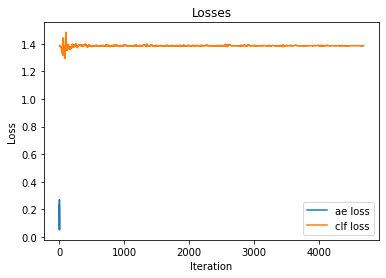

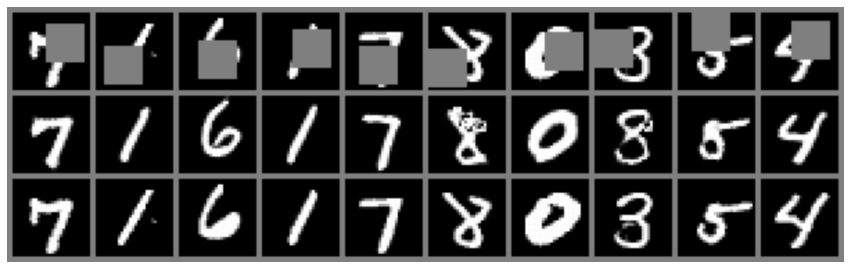

In [9]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [4]:
class ClassModel(nn.Module):
    def __init__(self, n, hd):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
                                  nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), 
                                  nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU()
                                 )

        self.lin = nn.Sequential(nn.Linear(4 * 4 * 128, hd), nn.ReLU(),
                                 nn.Linear(hd, hd), nn.ReLU(), nn.Linear(hd, n)
                                )

    def forward(self, x):
        return self.lin(self.conv(x).flatten(1))

In [5]:
class RotationsPredictionsModel(nn.Module): 
    def __init__(self, n, hd): 
        super().__init__()
        self.m = ClassModel(n=n, hd=hd)

    def fit(self, train_data, epochs, lr): 
        self.train()
        opt = Adam(self.m.parameters(), lr=lr)
        lo, shares = [], []
        for _ in trange(epochs):
            tot = 0
            trues = 0
            for b, y in tqdm(train_data): 
                bs = b.shape[0]
                y = y.to(device)
                b = b.float().to(device)
                y_hat = self.m(b)
                calc_loss = nn.CrossEntropyLoss(reduction="sum")
                loss = calc_loss(y_hat, y) 
                loss /= bs
                opt.zero_grad()
                loss.backward()
                opt.step()
                trues += (torch.argmax(y_hat, dim=1) == y).sum().item()
                tot += bs
                lo.append(loss.item())
            shares.append(trues / tot)
        return lo, shares

In [6]:
class Rotate(data.Dataset): 
    def __init__(self, dataset): 
        self.s = (dataset.data / 255) * 2 - 1

    def __getitem__(self, idx):
        k = np.random.randint(0, 3)
        res = np.rot90(self.s[idx], k=k)[np.newaxis, ...]
        return res.copy(), k

    def __len__(self): 
        return len(self.s)

In [8]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

    bs = 128
    n_e = 10
    lr = 1e-3
    n = 4
    hd = 128

    model = RotationsPredictionsModel(n=n, hd=hd).to(device)
    train_data = Rotate(train_data)
    train_data = data.DataLoader(train_data, batch_size=bs, shuffle=True)
    loss, shares = model.fit(train_data, epochs=n_e, lr=lr)
    return loss, shares 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

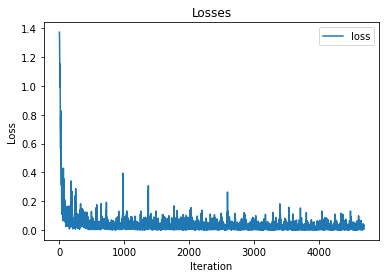

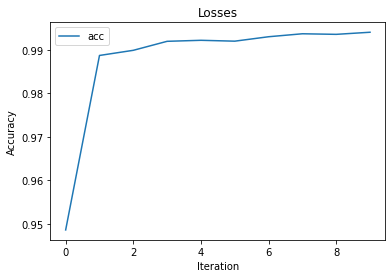

In [9]:
q2_results(q2)